# Import packages



In [ ]:
import pandas as pd
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
import scipy.signal
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
data = dataframe.drop(140, axis=1)
ecg_data = pd.Series([item for sublist in data.values for item in sublist])
ecg_data = ecg_data[:10000]

In [ ]:
def normalise(data):
  min_val = data.min()
  max_val = data.max()
  data = (data - min_val) / (max_val - min_val)
  return data

In [ ]:
ecg_data = normalise(ecg_data)

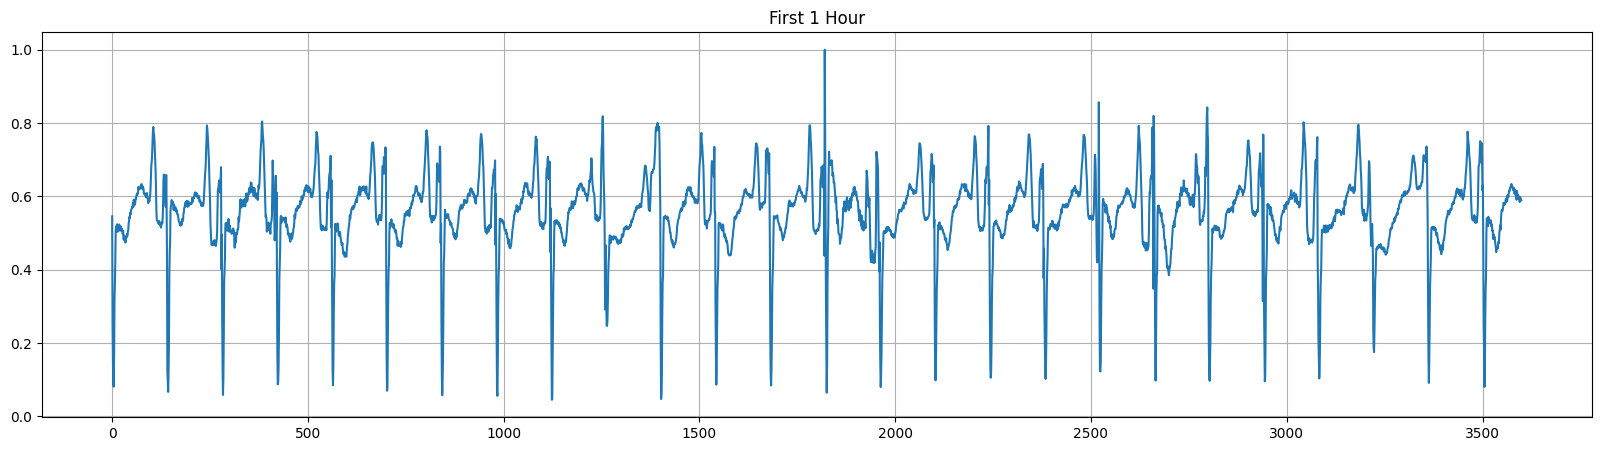

In [ ]:
first_ecg = ecg_data.iloc[:3600]

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(np.arange(3600), first_ecg)
plt.title("First 1 Hour")
plt.show()

In [ ]:
x = []
y = []

for i in range(60, len(ecg_data)):
  features = ecg_data.iloc[i-60:i]
  target = ecg_data.iloc[i]

  x.append(features.values.reshape(1, -1))
  y.append(target)

x = np.array(x)
y = np.array(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
x_train.shape

(7952, 1, 60)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[2], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, ConvLSTM1D, MaxPooling2D,Dropout


In [ ]:
x_train = x_train.reshape((x_train.shape[0], 1, 60, 1))
x_test = x_test.reshape((x_test.shape[0], 1, 60, 1))

In [ ]:
model = Sequential()
model.add(ConvLSTM1D(filters=64, kernel_size=1, input_shape=(1, 60, 1), return_sequences=True))
model.add(ConvLSTM1D(filters=64, kernel_size=1, return_sequences=True))
model.add(ConvLSTM1D(filters=64, kernel_size=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_4 (ConvLSTM1D)  (None, 1, 60, 64)         16896     
                                                                 
 conv_lstm1d_5 (ConvLSTM1D)  (None, 1, 60, 64)         33024     
                                                                 
 conv_lstm1d_6 (ConvLSTM1D)  (None, 60, 64)            33024     
                                                                 
 flatten_2 (Flatten)         (None, 3840)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                245824    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse' ])

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=8,
    validation_data=(x_test, y_test)
)

Epoch 1/15
994/994 [==============================] - 20s 14ms/step - loss: 0.0145 - mae: 0.0848 - mse: 0.0145 - val_loss: 0.0028 - val_mae: 0.0372 - val_mse: 0.0028
Epoch 2/15
994/994 [==============================] - 13s 13ms/step - loss: 0.0046 - mae: 0.0515 - mse: 0.0046 - val_loss: 0.0024 - val_mae: 0.0305 - val_mse: 0.0024
Epoch 3/15
994/994 [==============================] - 12s 12ms/step - loss: 0.0030 - mae: 0.0403 - mse: 0.0030 - val_loss: 0.0017 - val_mae: 0.0200 - val_mse: 0.0017
Epoch 4/15
994/994 [==============================] - 13s 13ms/step - loss: 0.0023 - mae: 0.0332 - mse: 0.0023 - val_loss: 0.0019 - val_mae: 0.0237 - val_mse: 0.0019
Epoch 5/15
994/994 [==============================] - 13s 13ms/step - loss: 0.0020 - mae: 0.0294 - mse: 0.0020 - val_loss: 0.0016 - val_mae: 0.0193 - val_mse: 0.0016
Epoch 6/15
994/994 [==============================] - 13s 14ms/step - loss: 0.0017 - mae: 0.0260 - mse: 0.0017 - val_loss: 0.0020 - val_mae: 0.0268 - val_mse: 0.0020
Epoc

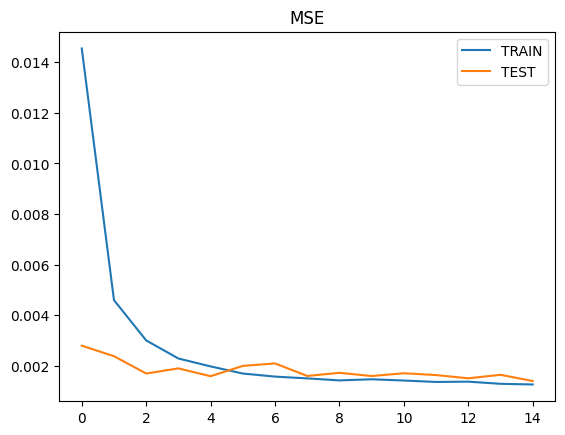

In [ ]:
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
plt.title("MSE")
plt.legend(["TRAIN" , "TEST"])
plt.show()

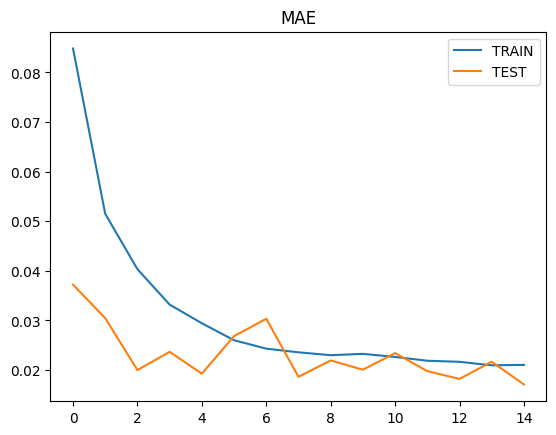

In [ ]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("MAE")
plt.legend(["TRAIN" , "TEST"])
plt.show()

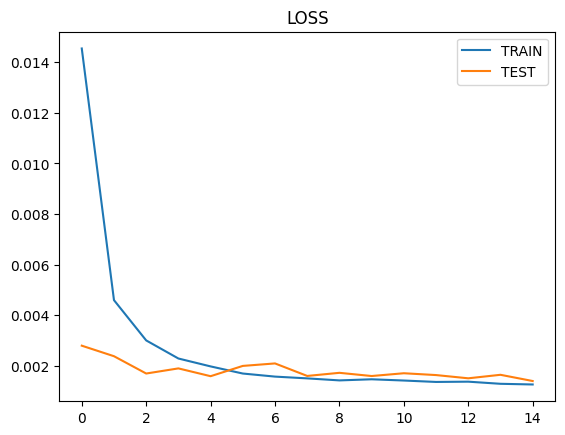

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("LOSS")
plt.legend(["TRAIN" , "TEST"])
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  epsilon = 1e-7
  return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)) * 100)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
from math import log

y_pred = model.predict(x_test)

r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("MSE :", mse)
print("MAE :" ,mae)
print("RMSE :" ,rmse)
print("R2_score :",r2)
print("MAE :" ,mape)

63/63 [==============================] - 2s 4ms/step
MSE : 0.0014001266634522968
MAE : 0.01709706194832592
RMSE : 0.037418266441035145
R2_score : 0.881809377375866
MAE : 27.911021762216308


In [ ]:
model.save("convlstm1d1yr.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/convlstm1d1yr.h5')

In [ ]:
last_data = ecg_data.tail(60)
last_data = last_data.to_numpy()

In [ ]:
result = []
prediction_steps = 60
for i in range(prediction_steps):
  prediction = model.predict(last_data.reshape(-1, 1, 60, 1))[0][0]
  result.append(prediction)
  last_data = np.append(last_data[1:], prediction)

1/1 [==============================] - 0s 18ms/step


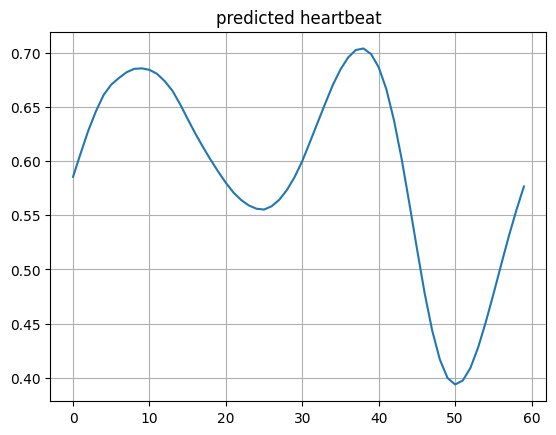

In [ ]:
plt.grid()
plt.plot(np.arange(60), result)
plt.title("predicted heartbeat")
plt.show()

In [ ]:
last_actual_data = ecg_data.tail(60)
all_values = last_actual_data.tolist()

In [ ]:
all_values.extend(result)

In [ ]:
actual_values = all_values[:60]
predicted_values = all_values[60:]
len(actual_values)

60

In [ ]:
time_axis = np.arange(len(all_values))
time_axis = list(time_axis)

In [ ]:
print(f"Length of time_axis: {len(time_axis)}")
print(f"Length of actual_values: {len(actual_values)}")
print(f"Length of predicted_values: {len(predicted_values)}")

Length of time_axis: 120
Length of actual_values: 60
Length of predicted_values: 60


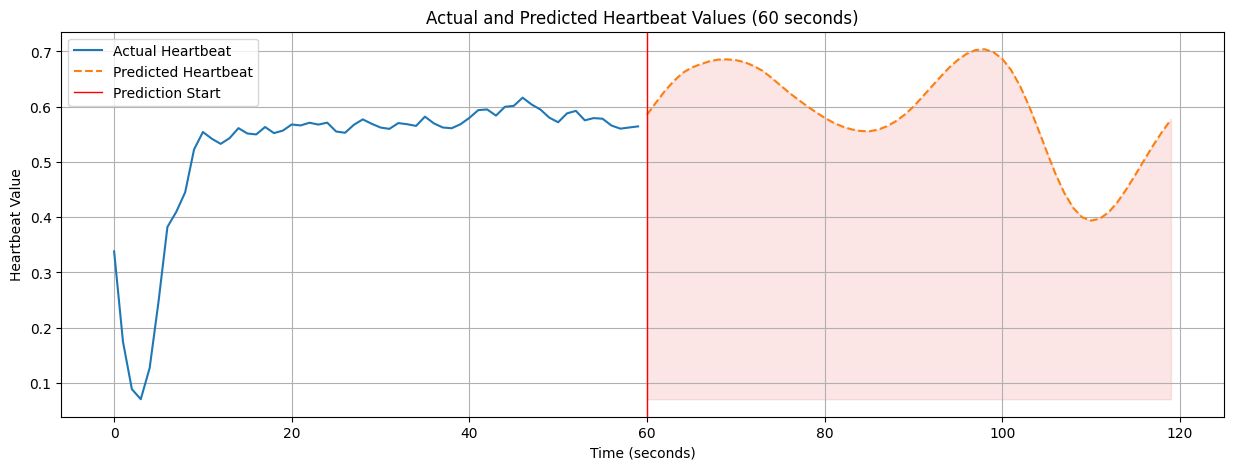

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(time_axis[:60], actual_values, label='Actual Heartbeat')
plt.plot(time_axis[60:], predicted_values, label='Predicted Heartbeat', linestyle='--')
plt.axvline(x=60, color='r', linestyle='-', linewidth=1, label='Prediction Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Heartbeat Value')
plt.title('Actual and Predicted Heartbeat Values (60 seconds)')
plt.legend()
plt.grid(True)

plt.fill_between(time_axis[60:], predicted_values, np.min(all_values), alpha=0.2, color='lightcoral')

plt.show()